# Welcome to the interactive Galaxy IPython Notebook.

You can access your data via the dataset number. For example, ``handle = open(get(42), 'r')``.
To save data, write your data to a file, and then call ``put('filename.txt')``. The dataset will then be available in your galaxy history.
Notebooks can be saved to Galaxy by clicking the large green button at the top right of the IPython interface.<br>
More help and informations can be found on the project [website](https://github.com/bgruening/galaxy-ipython).

## Configure things
Before we begin we need to install a few things that we will be using. This Jupyter instance runs within your own private docker, so you can install anything. Let's start with loading Jupyter R extension `rpy2.ipython`:

In [1]:
%load_ext rpy2.ipython

Next, we will install Bioconductor's DeSeq2 package using Conda, a powerful package manager:

In [2]:
!conda install -y -c cgat bioconductor-deseq2=1.6.3

Fetching package metadata ...........
Solving package specifications: ..........

# All requested packages already installed.
# packages in environment at /opt/conda:
#
bioconductor-deseq2       1.6.3                         0    cgat


Finally we will load two python libraries: `pandas` and `os`. `Pandas` will allow us to easily manipulate tabular datasets and `os` will be needed to parse file names. 

In [3]:
import pandas as pd
import os

## Import data from Galaxy history
To import datasets from Galaxy's history into Jupyter we will use dataset numbers. 
In this particular case we have four datasets: WT1, WT2, SNF2_1, and SNF2_2. We pass history numbers of these datasets into a Python list as `[24,23,22,21]`. In your particular case these numbers **may be different** for change them accordingly. Take care to have wildtype (WT) datasets first and mutanats (SNF2) last:

In [4]:
my_datasets = [24,23,22,21]

Now we iterate over this list and use `get()` function to copy each dataset into Jupyter

In [5]:
for dataset in my_datasets:
    get(dataset)

Use shell `ls` command should show files names 24,23 ... and so on (of course if you used different numbers they will be named differently):

In [6]:
!ls

21  22	23  24	28  ipython_galaxy_notebook.ipynb


Below we define a function `make_df` that create a [dataframe](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) (the code is from [notsoconsusing](http://notconfusing.com/joining-many-dataframes-at-once-in-pandas-n-ary-join/)):

In [7]:
def make_df(filename):
    df = pd.read_table(filename)
    name = (os.path.basename(filename)).split('.')[0]
    df.columns = [name, name+'_ct']
    return df

Now we use the above function to generate dataframes for each dataset in the list `my_datasets`:

In [8]:
dfs = [make_df(str(dataset)) for dataset in my_datasets]

Now we are joining these datasets on gene names to have a table where each row is a gene and each column contains read counts for thois gene in each dataset (this function is from [notsoconsusing](http://notconfusing.com/joining-many-dataframes-at-once-in-pandas-n-ary-join/)):

In [9]:
def join_dfs(ldf, rdf):
    return ldf.join(rdf, how='inner')

final_df = reduce(join_dfs, dfs) #that's the magic
final_df.head()

,24,24_ct,23,23_ct,22,22_ct,21,21_ct
0,Q0017,0,Q0017,0,Q0017,0,Q0017,0
1,Q0032,0,Q0032,0,Q0032,0,Q0032,0
2,Q0045,0,Q0045,2,Q0045,0,Q0045,5
3,Q0050,2,Q0050,1,Q0050,5,Q0050,1
4,Q0055,0,Q0055,5,Q0055,3,Q0055,1


You will see that gene names are redundant and only the first can be saved. Below we create a list that would contain the numbers (ids) of columns to be removed:

In [10]:
columns = []
for i in range(len(list(final_df))):
    if ( i > 1 and i%2 == 0 ):
        columns.append(i)

And the columns tobe removed are:

In [11]:
columns

[2, 4, 6]

Now we will actually drop them and rename the first column as `gene_id`:

In [12]:
counts = final_df.drop(final_df.columns[columns], axis=1)  
counts = counts.rename(columns={ list(counts)[0]: "gene_id"})
counts.head()

,gene_id,24_ct,23_ct,22_ct,21_ct
0,Q0017,0,0,0,0
1,Q0032,0,0,0,0
2,Q0045,0,2,0,5
3,Q0050,2,1,5,1
4,Q0055,0,5,3,1


The rest of the data analysis will be performed in `R`, so we will input Pandas dataframe `counts` into `R`:

In [13]:
%R -i counts

## Massaging the data
Let's take a look at the first several row of this dataframe:

In [14]:
%%R
head(counts)

  gene_id X24_ct X23_ct X22_ct X21_ct
0   Q0017      0      0      0      0
1   Q0032      0      0      0      0
2   Q0045      0      2      0      5
3   Q0050      2      1      5      1
4   Q0055      0      5      3      1
5   Q0060      0      0      0      0


Next, we will use this R expression to name all rows after gene names. In this case the gene names are stored in column "`gene_id`" hence the `<- counts$gene_id` expression:

In [15]:
%%R
row.names(counts) <- counts$gene_id

And now if we look at the few rows of `read.counts` dataframe we will see that rows are named not 1, 2, 3, etc but Q0010, Q0017 etc:

In [16]:
%%R
head(counts)

      gene_id X24_ct X23_ct X22_ct X21_ct
Q0017   Q0017      0      0      0      0
Q0032   Q0032      0      0      0      0
Q0045   Q0045      0      2      0      5
Q0050   Q0050      2      1      5      1
Q0055   Q0055      0      5      3      1
Q0060   Q0060      0      0      0      0


Now we will remove the column containing names using not so intuitive R syntax below:

In [17]:
%%R
counts <- counts[ , -c(1)]

Let's check if it is actually removed:

In [18]:
%%R
head(counts)

      X24_ct X23_ct X22_ct X21_ct
Q0017      0      0      0      0
Q0032      0      0      0      0
Q0045      0      2      0      5
Q0050      2      1      5      1
Q0055      0      5      3      1
Q0060      0      0      0      0


Give sensible names (conditions) to columns within the dataframe:

In [19]:
%%R
names(counts) <- c("WT_1", "WT_2", "SNF2_1", "SNF2_2")

Check that this is in fact the case:

In [20]:
%%R
head(counts)

      WT_1 WT_2 SNF2_1 SNF2_2
Q0017    0    0      0      0
Q0032    0    0      0      0
Q0045    0    2      0      5
Q0050    2    1      5      1
Q0055    0    5      3      1
Q0060    0    0      0      0


Here we will create a new dataframe called `read.count_noZero` by removing all rows from the original dataframe (`read.counts`) where read counts are zero for all conditions:

In [21]:
%%R
rc.keep <- rowSums(counts) > 0
read.counts_noZero <- counts[rc.keep,]

No rows with all zeros are now visible in the first few lines of the data:

In [22]:
%%R
head(read.counts_noZero)

      WT_1 WT_2 SNF2_1 SNF2_2
Q0045    0    2      0      5
Q0050    2    1      5      1
Q0055    0    5      3      1
Q0085    0    1      1      0
Q0105    0    1      0      0
Q0120    0    0      2      0


## Normalizing counts with DESeq2
Tell R to use DESeq2 library:

In [23]:
%%R
library ( DESeq2 )

/opt/conda/envs/python2/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: S4Vectors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/conda/envs/python2/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: stats4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/conda/envs/python2/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: BiocGenerics

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/conda/envs/python2/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/conda/envs/python2/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: 'BiocGenerics'


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/conda/

Now for DESeq2 to work we need to create another dataframe that maps sample name to a conditions. In our example here we have two conditions:
  * WT = wildtype
  * SNF2 = snf2
  
 Each of these conditions has two samples (replicates): WT1 and WT2 as well as SNF2_1 and SNF2_2. So we will create a new dataframe called `sample.info` that will hold this information:

In [24]:
%%R
sample.info <- data.frame(condition = c( rep("WT", 2), rep("SNF2", 2)), 
                          row.names = c(paste("WT", c(1:2), sep="_"),
                                        paste("SNF2", c(1:2),sep="_")) )

In [25]:
%%R
head(sample.info)

       condition
WT_1          WT
WT_2          WT
SNF2_1      SNF2
SNF2_2      SNF2


We need to generate DESeq2 dataset:

In [26]:
%%R

DESeq.ds <- DESeqDataSetFromMatrix( countData = read.counts_noZero , 
                                   colData = sample.info , design = ~ condition )

The following command will sum read counts for all four samples and thus inform us about the library sizes:

In [27]:
%R colSums ( read.counts_noZero )

array([ 5294905.,  7095234.,  9379369.,  7905710.])

Here we will let DESeq2 to performs its statistical magic by estimating the size factors that will be used in normalization:

In [28]:
%R DESeq.ds <- estimateSizeFactors ( DESeq.ds )

<RS4 - Python:0x7f1dbc3f1cf8 / R:0xa0d03a0>

Now we will perform the normalization:

In [29]:
%R counts.normalized <- counts ( DESeq.ds , normalized = TRUE )

array([[  0.        ,   2.05379072,   0.        ,   4.37802013],
       [  3.24010321,   1.02689536,   3.40081834,   0.87560403],
       [  0.        ,   5.13447679,   2.040491  ,   0.87560403],
       ..., 
       [ 77.7624771 ,  81.1247333 ,  72.09734882,  69.17271801],
       [  6.48020643,   7.18826751,   2.040491  ,   1.75120805],
       [ 66.42211586,  27.72617467,  28.56687406,  36.77536907]])

And also perform log2 transformation:

In [30]:
%R log.norm.counts <- log2( counts.normalized + 1)

array([[ 0.        ,  1.61060119,  0.        ,  2.42707515],
       [ 2.08409938,  1.01927161,  2.13777182,  0.90735528],
       [ 0.        ,  2.6169403 ,  1.60430432,  0.90735528],
       ..., 
       [ 6.29943658,  6.35974488,  6.19174718,  6.13283834],
       [ 2.90307808,  3.03355824,  1.60430432,  1.46006524],
       [ 6.07515   ,  4.84429398,  4.88590982,  5.23937395]])

To appreciate the effect of log2 transformation let's plot non-transformed counts:

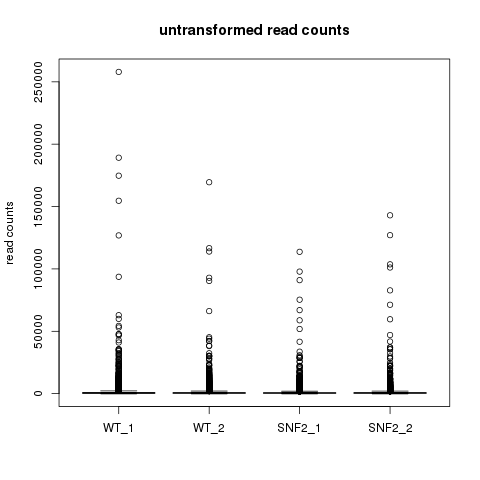

In [31]:
%%R
boxplot( counts.normalized , notch = TRUE ,
        main = "untransformed read counts" , ylab = "read counts" )

followed by transformed ones:

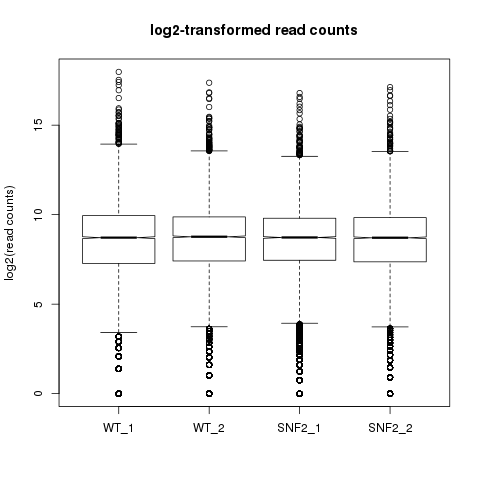

In [32]:
%%R
boxplot( log.norm.counts , notch = TRUE ,
        main = "log2-transformed read counts" , ylab = "log2(read counts)" )

## Shrinking varinance
Read count data is [heteroscedastic](https://en.wikipedia.org/wiki/Heteroscedasticity). In this particular case there a greater variance among expression estimates for genes where read count is low. This can be visualized by plotting log2 normalized contans for two conditions against each other:

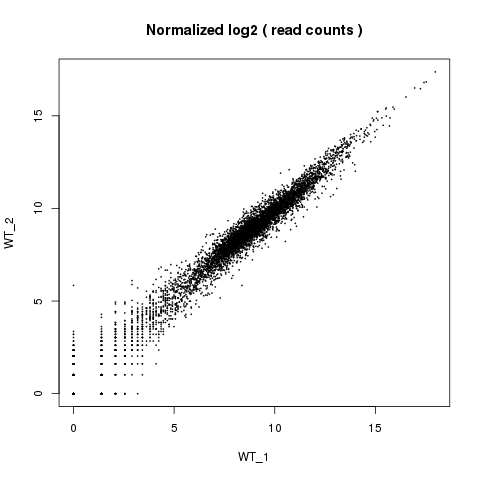

In [33]:
%%R
plot (log.norm.counts [ ,1:2] , cex =.1 , main = "Normalized log2 ( read counts )" )

The DESeq2 allows to adjust for heteroscedasticity by assigning more homogeneous read to genes with low counts, so they resemble genes with high counts. This is performed using the `rlog` function:

In [34]:
%%R
rlog.DESeq.sumExp <- rlog( DESeq.ds , blind = TRUE )
rlog.norm.counts <- assay( rlog.DESeq.sumExp )

Now if we visualize the same relationship using `rlog` transformed counts we will see a much "narrower" plot:

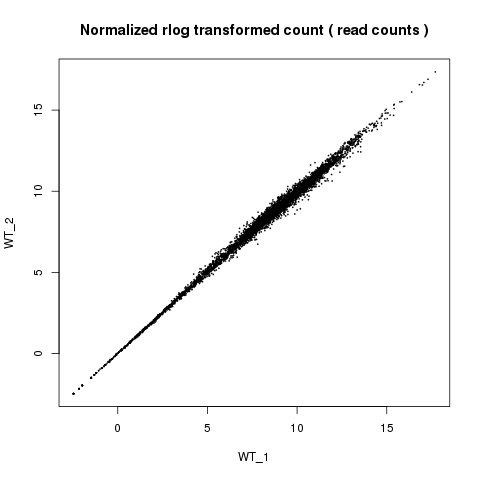

In [35]:
%%R
plot (rlog.norm.counts [ ,1:2] , cex =.1 , main = "Normalized rlog transformed count ( read counts )" )

And so get the idea. You can continue exploring these (or other) data using this Jupyter notebook as a staring point.